<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/GDSTK_CPW_Feed_Coupled_to_Resonator%2BCross_Cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code is ran entirely in Google Colab and outputs a preview and GDS file. A coplanar waveguide geometry is used for the feedline and the resonator elements. Also, a cross capacitor is introduced. Although the Josephson Junctions are not drawn, they can be added by scripting their geometries using the GDSTK library or by drawing them in KLayout (open source layout software).

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 459.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 41.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


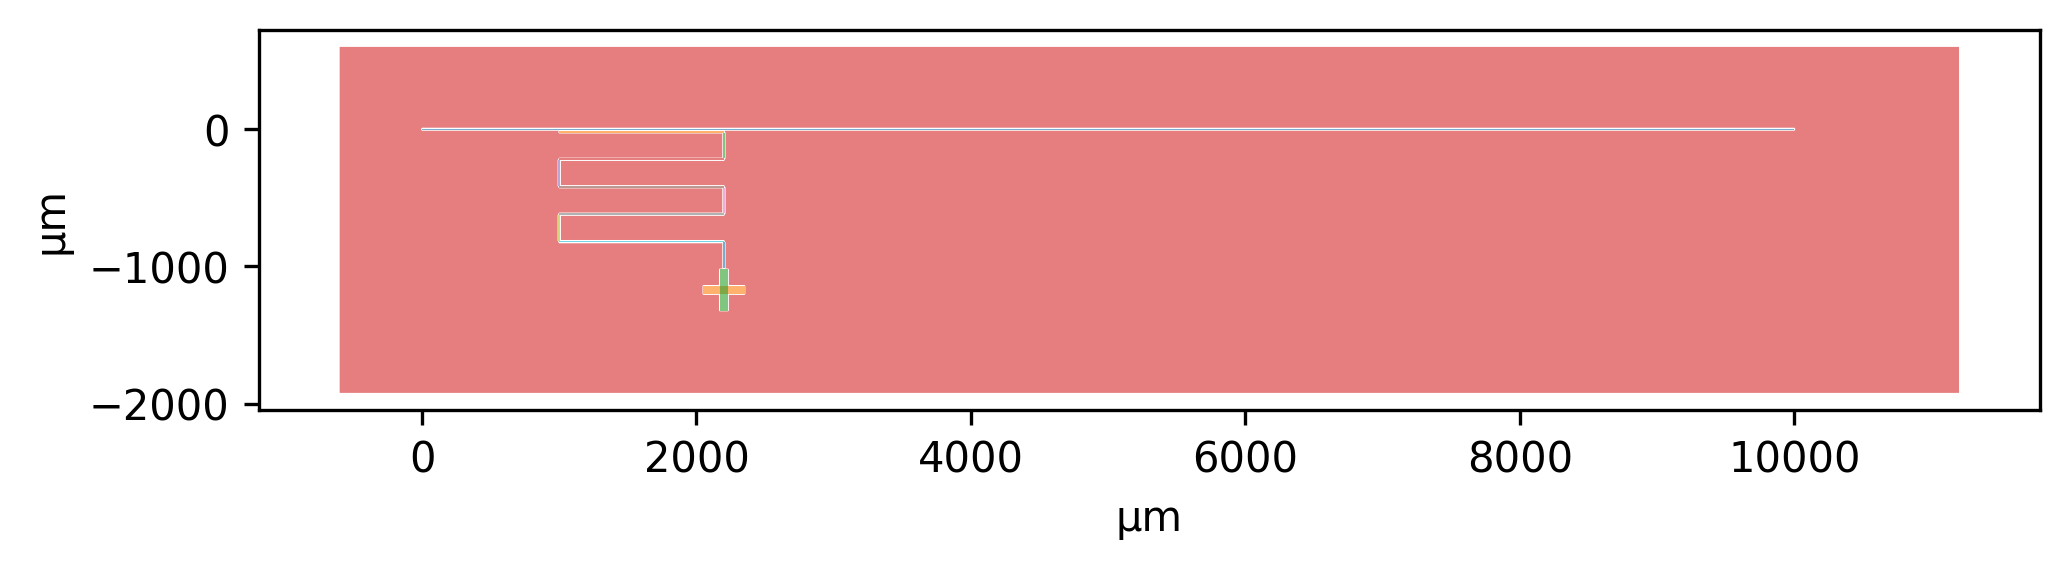

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# Google Colab Notebook — Planar CPW Feed‑Resonator–Transmon Layout (v1.1)
#
# Author : Onri Jay Benally
# Date   : 2025‑06‑04
# -------------------------------------------------------------
# Run Cell 0 → 5 in order. Cell 0 pins NumPy<2 for gdstk compatibility.
# -------------------------------------------------------------

# =============================================================
# Cell 0 — Dependency pin (MUST run first!)
# -------------------------------------------------------------
# gdstk 0.9.x wheels are compiled against NumPy 1.26; Colab ships
# with NumPy 2.x by default. We install a compatible NumPy wheel
# *before* pulling in gdstk.  A restart is **not** required.
# =============================================================
!pip -q install "numpy<2.0" gdstk==0.9.41 matplotlib

# =============================================================
# Cell 1 — Imports & Matplotlib setup
# -------------------------------------------------------------
import gdstk
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300  # crisp preview

# -------------------------------------------------------------
# Preview helper works whether Cell.plot exists or not
# -------------------------------------------------------------

def preview(cell, figsize=(7, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    if hasattr(cell, "plot"):
        cell.plot(ax)
    else:
        for poly in cell.polygons:
            pts = poly.points
            ax.fill(*zip(*pts), lw=0.3, alpha=0.6)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# =============================================================
# Cell 2 — Technology / Geometry Parameters
# -------------------------------------------------------------
tech = dict(
    w_feed = 10.0,
    g_feed = 6.0,
    w_res  = 12.0,
    g_res  = 6.0,
    lambda_quarter = 6000.0,   # µm (≈ λ_g/4 at 5 GHz)
    n_meanders     = 5,
    elbow_radius   = 100.0,    # µm
    pad_length     = 300.0,
    pad_width      = 60.0,
    jj_overlap     = 2.0,
    d_feed_res     = 2.0,      # feed ↔ meander vertical gap
    d_res_qb       = 2.0,      # meander ↔ qubit vertical gap
    margin         = 600.0,    # chip frame margin
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # for ground clearance

# =============================================================
# Cell 3 — Builder helpers
# -------------------------------------------------------------

def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    w = width
    return [gdstk.rectangle((x0, y0 - w / 2), (x0 + length, y0 + w / 2))]


def build_meander(origin, p):
    x0, y0 = origin
    seg = p["lambda_quarter"] / p["n_meanders"]
    w = p["w_res"]
    r = p["elbow_radius"]

    poly = []
    direction = 1
    cx, cy = x0, y0
    for _ in range(p["n_meanders"]):
        # horizontal section
        poly.append(gdstk.rectangle((cx, cy - w / 2), (cx + direction * seg, cy + w / 2)))
        cx += direction * seg
        # vertical drop to next row
        poly.append(gdstk.rectangle((cx - w / 2, cy - w / 2), (cx + w / 2, cy - (2 * r - w / 2))))
        cy -= 2 * r
        direction *= -1
    # Return polygons and bottom‑left corner of last horizontal (for qubit placement)
    bottom_x = cx
    bottom_y = cy
    return poly, (bottom_x, bottom_y)


def build_cross_qubit(center, p):
    cx, cy = center
    L, W = p["pad_length"], p["pad_width"]
    return [
        gdstk.rectangle((cx - L / 2, cy - W / 2), (cx + L / 2, cy + W / 2)),
        gdstk.rectangle((cx - W / 2, cy - L / 2), (cx + W / 2, cy + L / 2)),
    ]

# =============================================================
# Cell 4 — Chip assembly & ground carving
# -------------------------------------------------------------

def build_full_chip(p):
    lib = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")

    conductors = []

    # ---------------- Feedline (top) ----------------
    feed_len = 10000.0
    feed = build_straight_cpw((0.0, 0.0), feed_len, p["w_feed"])
    cell.add(*feed)
    conductors.extend(feed)

    # ---------------- Meander (middle) -------------
    res_origin = (
        1000.0,  # 1 mm in x
        -(p["w_feed"] / 2 + p["g_feed"] + p["d_feed_res"] + p["w_res"] / 2),
    )
    meander_polys, _ = build_meander(res_origin, p)
    cell.add(*meander_polys)
    conductors.extend(meander_polys)

    # ---------------- Cross qubit (bottom) ---------
    seg = p["lambda_quarter"] / p["n_meanders"]
    bottom_x = res_origin[0] + seg  # valid for odd n_meanders
    bottom_y = res_origin[1] - p["n_meanders"] * 2 * p["elbow_radius"]

    qb_center = (
        bottom_x,
        bottom_y - p["d_res_qb"] - p["pad_length"] / 2,
    )
    cross = build_cross_qubit(qb_center, p)
    cell.add(*cross)
    conductors.extend(cross)

    # ---------------- Ground plane -----------------
    conductor_union = gdstk.boolean(conductors, [], "or")
    clearance = p["g_max"] + 0.1
    keepout = gdstk.offset(conductor_union, clearance, join="round")

    chip_w = feed_len + 2 * p["margin"]
    chip_h_pos = p["margin"]
    chip_h_neg = abs(qb_center[1]) + p["pad_length"] / 2 + p["margin"]
    full_ground = gdstk.rectangle((-p["margin"], -chip_h_neg), (chip_w, chip_h_pos))

    ground = gdstk.boolean(full_ground, keepout, "not")
    cell.add(*ground)

    return lib

# =============================================================
# Cell 5 — Preview & GDS export
# -------------------------------------------------------------
lib = build_full_chip(tech)
preview(lib.top_level()[0])

lib.write_gds("cpw_layout_v1.gds")

try:
    from google.colab import files
    files.download("cpw_layout_v1.gds")
except ModuleNotFoundError:
    print("Running locally – GDS saved to working directory.")

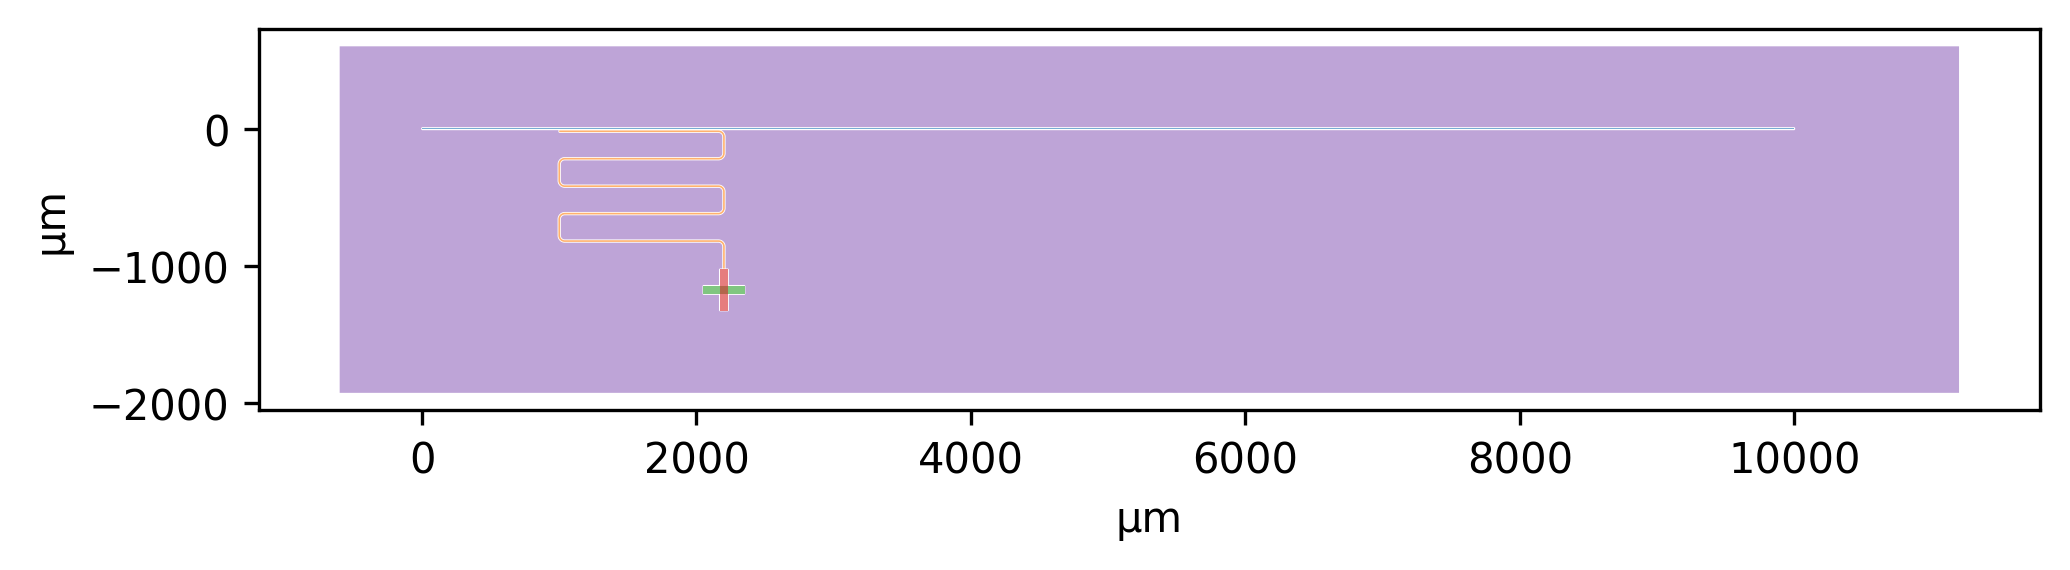

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# Google Colab Notebook — Planar CPW Feed‑Resonator–Transmon Layout (v2)
#
# Author : Onri Jay Benally — cross capacitor shifted
# Date   : 2025‑06‑04
# -------------------------------------------------------------
# Run Cell 1 → 5 in order. Final cell writes `cpw_layout_v2.gds`.
# -------------------------------------------------------------
# Cell 1 — Setup & Imports (pin GDSTK for stable API)
# -------------------------------------------------------------
!pip -q install gdstk==0.9.41 matplotlib

import gdstk
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300  # crisp preview

# -------------------------------------------------------------
# Preview helper works whether Cell.plot exists or not
# -------------------------------------------------------------

def preview(cell, figsize=(7, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    if hasattr(cell, "plot"):
        cell.plot(ax)
    else:
        for poly in cell.polygons:
            pts = poly.points
            ax.fill(*zip(*pts), lw=0.3, alpha=0.6)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# Cell 2 — Technology / Geometry Parameters
# -------------------------------------------------------------
tech = dict(
    w_feed = 10.0,
    g_feed = 6.0,
    w_res  = 12.0,
    g_res  = 6.0,
    lambda_quarter = 6000.0,   # µm (≈ λ_g/4 at 5 GHz)
    n_meanders     = 5,
    elbow_radius   = 100.0,    # µm
    fillet         = 40.0,     # µm bend radius for FlexPath
    pad_length     = 300.0,
    pad_width      = 60.0,
    jj_overlap     = 2.0,
    d_feed_res     = 2.0,      # feed ↔ meander vertical gap
    d_res_qb       = 2.0,      # meander ↔ qubit vertical gap (before extra shift)
    margin         = 600.0,    # chip frame margin
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # for ground clearance

# -------------------------------------------------------------
# Cell 3 — Builder helpers
# -------------------------------------------------------------

def build_straight_cpw(origin, length, width):
    x0, y0   = origin
    w        = width
    return [gdstk.rectangle((x0, y0 - w/2), (x0 + length, y0 + w/2))]


def build_meander(origin, p):
    x0, y0   = origin
    seg      = p['lambda_quarter'] / p['n_meanders']
    w        = p['w_res']
    r        = p['elbow_radius']

    pts      = [(x0, y0)]
    direction = 1
    cx, cy    = x0, y0
    for _ in range(p['n_meanders']):
        cx += direction * seg
        pts.append((cx, cy))          # horizontal
        cy -= 2 * r
        pts.append((cx, cy))          # vertical leg
        direction *= -1

    # Build FlexPath with smooth bends
    path = gdstk.FlexPath(
        pts,
        w,
        bend_radius=p['fillet'],
        simple_path=True,
    )
    polys = path.to_polygons()
    return polys, (cx, cy)


def build_cross_qubit(center, p):
    cx, cy = center
    L, W   = p['pad_length'], p['pad_width']
    return [
        gdstk.rectangle((cx - L/2, cy - W/2), (cx + L/2, cy + W/2)),
        gdstk.rectangle((cx - W/2, cy - L/2), (cx + W/2, cy + L/2)),
    ]

# -------------------------------------------------------------
# Cell 4 — Chip assembly & ground carving
# -------------------------------------------------------------

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")

    conductors = []

    # ---------------- Feedline (top) ----------------
    feed_len = 10000.0
    feed     = build_straight_cpw((0.0, 0.0), feed_len, p['w_feed'])
    cell.add(*feed)
    conductors.extend(feed)

    # ---------------- Meander (middle) -------------
    res_origin = (
        1000.0,  # 1 mm in x
        -(p['w_feed']/2 + p['g_feed'] + p['d_feed_res'] + p['w_res']/2),
    )
    meander_polys, (meander_end_x, meander_end_y) = build_meander(res_origin, p)
    cell.add(*meander_polys)
    conductors.extend(meander_polys)

    # ---------------- Cross qubit (bottom) ---------
    # Shifted an additional 4 µm downwards per user request
    qb_center = (
        meander_end_x,
        meander_end_y - p['d_res_qb'] - p['pad_length']/2 - 4.0,
    )
    cross = build_cross_qubit(qb_center, p)
    cell.add(*cross)
    conductors.extend(cross)

    # ---------------- Ground plane -----------------
    conductor_union = gdstk.boolean(conductors, [], "or")
    clearance       = p['g_max'] + 0.1
    keepout         = gdstk.offset(conductor_union, clearance, join="round")

    chip_w = feed_len + 2 * p['margin']
    chip_h_pos = p['margin']
    chip_h_neg = abs(qb_center[1]) + p['pad_length']/2 + p['margin']
    full_ground = gdstk.rectangle((-p['margin'], -chip_h_neg), (chip_w, chip_h_pos))

    ground = gdstk.boolean(full_ground, keepout, "not")
    cell.add(*ground)

    return lib

# -------------------------------------------------------------
# Cell 5 — Preview & GDS export
# -------------------------------------------------------------
lib = build_full_chip(tech)
main_cell = lib.top_level()[0]
preview(main_cell)

lib.write_gds("cpw_layout_v2.gds")
try:
    from google.colab import files
    files.download("cpw_layout_v2.gds")
except ModuleNotFoundError:
    print("Running locally – GDS saved to working directory.")

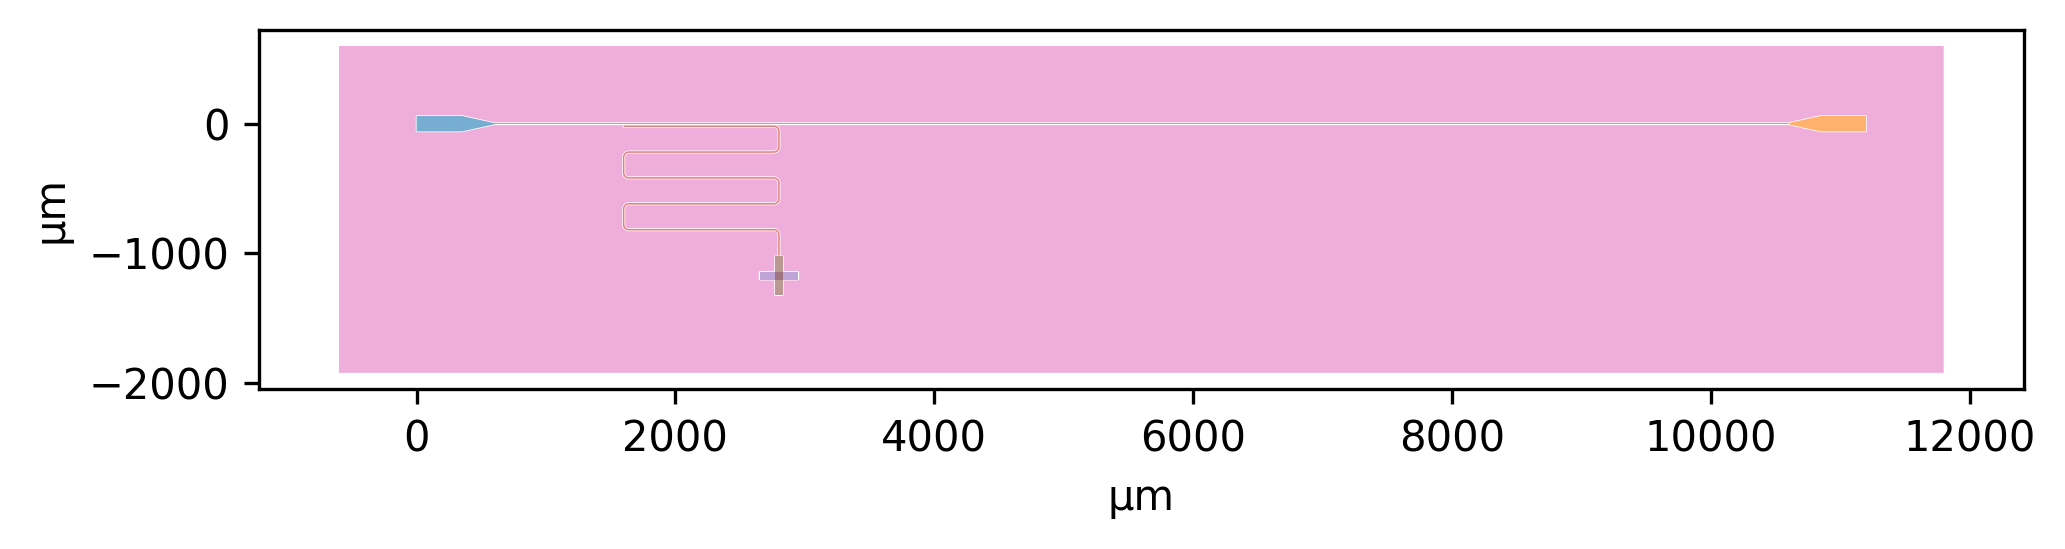

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# Google Colab Notebook — Planar CPW Feed-Resonator–Transmon Layout (v2-fixed, launch-pad update)
#
# Author : Onri Jay Benally
# Date   : 2025-06-04
# ------------------------------------------------------------------
# RUN CELLS 0 → 5 IN ORDER. Final cell writes `cpw_layout_v2.gds`.
# ------------------------------------------------------------------

# =============================================================
# Cell 0 — Dependency pin (NumPy < 2 for gdstk 0.9.x compatibility)
# =============================================================
!pip -q install "numpy<2.0" gdstk==0.9.41 matplotlib

# =============================================================
# Cell 1 — Imports & Matplotlib setup
# =============================================================
import gdstk
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 300  # crisp preview

# -------------------------------------------------------------
# Preview helper works whether Cell.plot exists or not
# -------------------------------------------------------------

def preview(cell, figsize=(7, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    if hasattr(cell, "plot"):
        cell.plot(ax)
    else:
        for poly in cell.polygons:
            ax.fill(*zip(*poly.points), lw=0.3, alpha=0.6)
    ax.set_aspect("equal")
    ax.set_xlabel("µm")
    ax.set_ylabel("µm")
    plt.tight_layout()
    plt.show()

# =============================================================
# Cell 2 — Technology / Geometry Parameters
# =============================================================
tech = dict(
    # --- Feed & resonator widths ---
    w_feed = 10.0,
    g_feed = 6.0,
    w_res  = 12.0,
    g_res  = 6.0,

    # --- λ/4 resonator geometry ---
    lambda_quarter = 6000.0,   # µm (≈ λ_g/4 at 5 GHz)
    n_meanders     = 5,
    elbow_radius   = 100.0,    # µm
    fillet         = 40.0,     # µm

    # ---- Launch-pad / taper ----
    w_pad         = 120.0,   # µm  pad width (signal)
    pad_len       = 350.0,   # µm  pad length (rectangular section)
    pad_taper_len = 250.0,   # µm  linear taper length from w_feed → w_pad

    # --- Capacitor (cross-qubit) pads ---
    cap_pad_len   = 300.0,   # µm  (cross arms)
    cap_pad_width = 60.0,    # µm

    # --- Qubit cross / spacing ---
    jj_overlap = 2.0,         # reserved for future use
    d_feed_res = 2.0,         # feed ↔ meander vertical gap
    d_res_qb   = 2.0,         # meander ↔ qubit vertical gap

    # --- Chip framing ---
    margin = 600.0,
)
tech["g_max"] = max(tech["g_feed"], tech["g_res"])  # for ground clearance

# =============================================================
# Cell 3 — Builder helpers
# =============================================================

def build_straight_cpw(origin, length, width):
    x0, y0 = origin
    return [gdstk.rectangle((x0, y0 - width / 2), (x0 + length, y0 + width / 2))]


def build_launch_pad(origin_x, y0, direction, p):
    """Return polygon consisting of linear taper + rectangular pad.

    origin_x – x-coordinate where taper meets the narrow feed.
    direction – ±1  (+1 extends +x, −1 extends −x).
    """
    w1 = p["w_feed"]
    w2 = p["w_pad"]  # updated width key
    t_len, pad_len = p["pad_taper_len"], p["pad_len"]

    x_feed      = origin_x
    x_taper_end = x_feed + direction * t_len
    x_pad_end   = x_taper_end + direction * pad_len

    pts = [
        (x_feed,      y0 + w1 / 2),
        (x_taper_end, y0 + w2 / 2),
        (x_pad_end,   y0 + w2 / 2),
        (x_pad_end,   y0 - w2 / 2),
        (x_taper_end, y0 - w2 / 2),
        (x_feed,      y0 - w1 / 2),
    ]
    return gdstk.Polygon(pts)


def build_meander(origin, p):
    x0, y0 = origin
    seg    = p["lambda_quarter"] / p["n_meanders"]
    w      = p["w_res"]
    r      = p["elbow_radius"]

    pts, cx, cy, direction = [(x0, y0)], x0, y0, 1
    for _ in range(p["n_meanders"]):
        cx += direction * seg
        pts.append((cx, cy))
        cy -= 2 * r
        pts.append((cx, cy))
        direction *= -1

    path = gdstk.FlexPath(pts, w, bend_radius=p["fillet"], simple_path=True)
    return path.to_polygons(), (cx, cy)


def build_cross_qubit(center, p):
    """Simple cross-style transmon: two orthogonal rectangles."""
    cx, cy = center
    L, W   = p["cap_pad_len"], p["cap_pad_width"]
    return [
        gdstk.rectangle((cx - L / 2, cy - W / 2), (cx + L / 2, cy + W / 2)),
        gdstk.rectangle((cx - W / 2, cy - L / 2), (cx + W / 2, cy + L / 2)),
    ]

# =============================================================
# Cell 4 — Chip assembly & ground carving
# =============================================================

def build_full_chip(p):
    lib  = gdstk.Library(unit=1e-6)
    cell = lib.new_cell("MAIN")
    conductors = []

    # --------- Launch pads & feed line ---------
    feed_origin_x = p["pad_len"] + p["pad_taper_len"]
    feed_len      = 10000.0  # distance between taper roots

    pad_left  = build_launch_pad(feed_origin_x, 0.0, -1, p)
    pad_right = build_launch_pad(feed_origin_x + feed_len, 0.0, +1, p)

    feed = build_straight_cpw((feed_origin_x, 0.0), feed_len, p["w_feed"])

    cell.add(pad_left, pad_right, *feed)
    conductors.extend([pad_left, pad_right, *feed])

    # --------- Meander resonator ---------
    res_origin = (
        feed_origin_x + 1000.0,  # 1 mm from left taper root
        -(p["w_feed"] / 2 + p["g_feed"] + p["d_feed_res"] + p["w_res"] / 2),
    )
    meander_polys, (meander_end_x, meander_end_y) = build_meander(res_origin, p)
    cell.add(*meander_polys)
    conductors.extend(meander_polys)

    # --------- Cross qubit ---------
    qb_center = (
        meander_end_x,
        meander_end_y - p['d_res_qb'] - p['cap_pad_len']/2 - 4.0,  # extra 4 µm shift
    )
    cross = build_cross_qubit(qb_center, p)
    cell.add(*cross)
    conductors.extend(cross)

    # --------- Ground plane ---------
    conductor_union = gdstk.boolean(conductors, [], "or")
    keepout = gdstk.offset(conductor_union, p["g_max"] + 0.1, join="round")

    chip_w = feed_len + 2 * (p["pad_len"] + p["pad_taper_len"]) + 2 * p["margin"]
    chip_h_pos = p["margin"]
    chip_h_neg = abs(qb_center[1]) + p["cap_pad_len"] / 2 + p["margin"]

    full_ground = gdstk.rectangle((-p["margin"], -chip_h_neg), (chip_w - p["margin"], chip_h_pos))
    ground = gdstk.boolean(full_ground, keepout, "not")
    cell.add(*ground)

    return lib

# =============================================================
# Cell 5 — Preview & GDS export
# =============================================================
lib = build_full_chip(tech)
main_cell = lib.top_level()[0]
preview(main_cell)

lib.write_gds("cpw_layout_v2.gds")
try:
    from google.colab import files
    files.download("cpw_layout_v2.gds")
except ModuleNotFoundError:
    print("Running locally – GDS saved to working directory.")

In [4]:
# =============================================================
# Cell 6 — SVG export (vector drawing of the full layout)
# =============================================================
# Choose export options
SVG_FILENAME = "cpw_layout_v2.svg"

# Recommended: white background for papers, small pad so content isn't clipped.
# scaling=1 keeps 1 layout unit → 1 SVG unit; increase if you want a larger on-screen view.
svg_kwargs = dict(
    scaling=1,           # overall scale factor of coordinates in the SVG
    precision=4,         # digits after scaling; reduces file size while preserving micrometer detail
    background="#FFFFFF",
    pad="2%"             # margin around the drawing (absolute units or percentage)
)

# Some viewers honor layer-specific styles; by default, everything is filled black.
# You can later assign layers to elements and map styles with (layer, datatype) keys, e.g.:
# shape_style = {(0, 0): {"fill": "#000000"}}
# main_cell.write_svg(SVG_FILENAME, shape_style=shape_style, **svg_kwargs)

# Export using gdstk's built-in writer
if hasattr(main_cell, "write_svg"):
    main_cell.write_svg(SVG_FILENAME, **svg_kwargs)
    print(f"Wrote SVG → {SVG_FILENAME}")
else:
    raise RuntimeError("This gdstk version lacks Cell.write_svg; upgrade gdstk to ≥0.9.x.")

# Colab download helper
try:
    from google.colab import files
    files.download(SVG_FILENAME)
except ModuleNotFoundError:
    print("Running locally – SVG saved to working directory.")

Wrote SVG → cpw_layout_v2.svg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# =============================================================
# Cell 6b — (Optional) Export the Matplotlib preview as SVG
# =============================================================
# This produces a figure-based SVG of the preview; useful for slides,
# but it is not layer-aware like the gdstk SVG above.
fig, ax = plt.subplots(figsize=(7, 4))
if hasattr(main_cell, "plot"):
    main_cell.plot(ax)
else:
    for poly in main_cell.polygons:
        ax.fill(*zip(*poly.points), lw=0.3, alpha=0.6)
ax.set_aspect("equal")
ax.set_xlabel("µm")
ax.set_ylabel("µm")
plt.tight_layout()
matplotlib_svg = "cpw_layout_v2_preview.svg"
fig.savefig(matplotlib_svg, format="svg", dpi=300)
plt.close(fig)
print(f"Wrote Matplotlib SVG preview → {matplotlib_svg}")

try:
    from google.colab import files
    files.download(matplotlib_svg)
except ModuleNotFoundError:
    pass


Wrote Matplotlib SVG preview → cpw_layout_v2_preview.svg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>